In [ ]:
import os
import numpy as np
import porespy as ps
from tqdm import tqdm

generation_path = "./runout{i}/generated_batch_{j}_samples.npy"
original_path   = "./runout{i}/original_batch_{j}_samples.npy"
out_dir = "./BUG_tpcf_uncertainty"
os.makedirs(out_dir, exist_ok=True)

N_RUNS = 20         # 20 sampling runs
N_BATCHES = 82      # each npy file with 4 samples, total 328 samples

for j in tqdm(range(N_BATCHES)):
    original = np.load(original_path.format(i=1, j=j))    
    n_per_batch = original.shape[0]                     

    for n in range(n_per_batch):
        orig_vol = np.squeeze(original[n]) 
        solid_fraction_orig = 1 - orig_vol.mean()
        tpcf_orig = ps.metrics.two_point_correlation(1-orig_vol)
        tpcf_orig.probability = tpcf_orig.probability * solid_fraction_orig

        dist = np.insert(tpcf_orig.distance, 0, 0.0)
        orig_prob = np.insert(tpcf_orig.probability, 0,  solid_fraction_orig)

        # reconstruct TPCF for the same sample (j,n) across 20 runs
        gen_probs = []
        for i in range(1, N_RUNS + 1):
            generations = np.load(generation_path.format(i=i, j=j))  # (4, 1, D, H, W)
            gen_vol = np.squeeze(generations[n])
            solid_fraction_generated = 1 - gen_vol.mean()
            tpcf_gen = ps.metrics.two_point_correlation(1-gen_vol)
            tpcf_gen.probability = tpcf_gen.probability * solid_fraction_generated
            tpcf_gen.probability = np.insert(tpcf_gen.probability, 0, solid_fraction_generated)
            gen_probs.append(tpcf_gen.probability)

        gen_probs = np.vstack(gen_probs)            
        mean_gen = gen_probs.mean(axis=0)

        global_id = j * n_per_batch + n

        out_csv = os.path.join(out_dir, f"sample_{global_id:04d}_tpcf.csv")
        np.savetxt(
            out_csv,
            np.vstack([dist, orig_prob, mean_gen]).T,
            delimiter=",",
            header="Distance,Original,Generated_Mean",
            comments=""
        )

Per-batch: 100%|██████████| 82/82 [29:00<00:00, 21.23s/it]


Loaded 328 samples


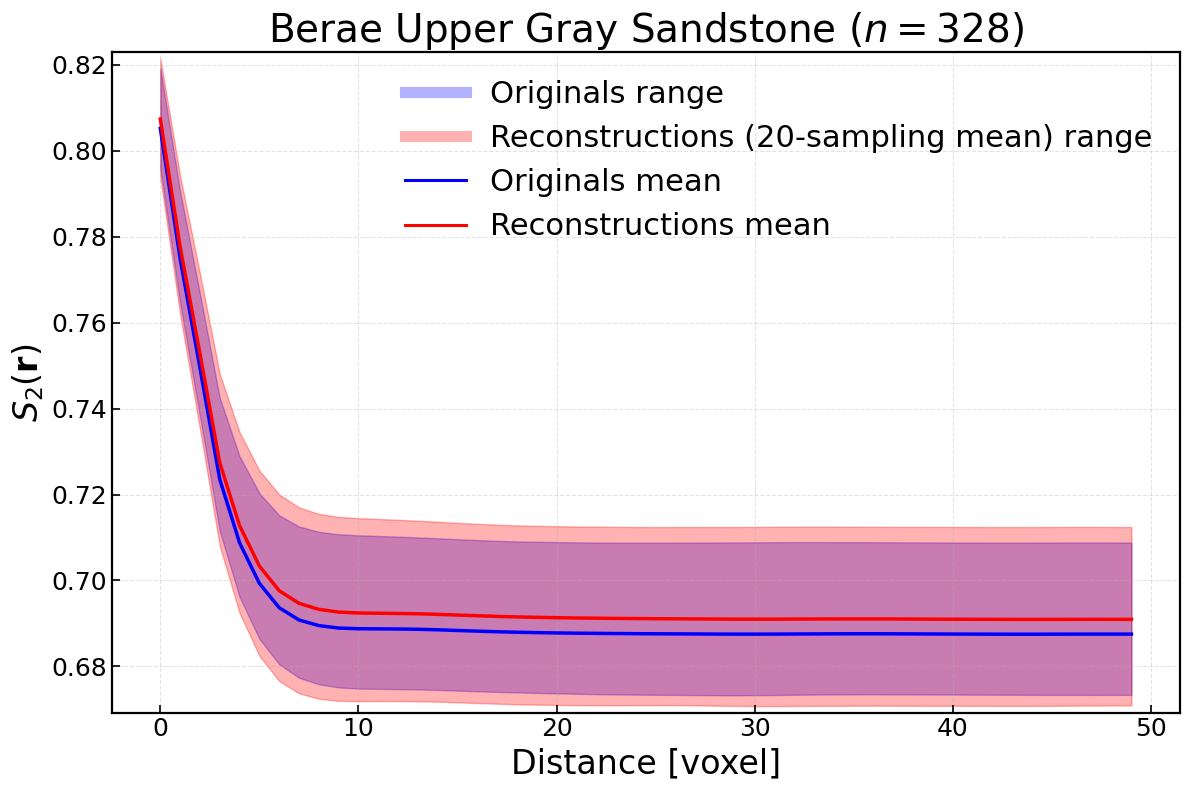

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import glob
import os

CSV_DIR = "./BUG_tpcf"   
files = sorted(
    glob.glob(os.path.join(CSV_DIR, "sample_*_tpcf_uncertainty.csv")),
    key=lambda p: int(os.path.basename(p).split("_")[1])
)
N = len(files)
print(f"Loaded {N} samples")     

dist = None
orig_list, genm_list, ci_list = [], [], []
ids = []
for fp in files:
    df = pd.read_csv(fp)
    if dist is None:
        dist = df["Distance"].to_numpy()
    orig_list.append(df["Original"].to_numpy())
    genm_list.append(df["Generated_Mean"].to_numpy())
    ids.append(int(os.path.basename(fp).split("_")[1]))

orig_arr = np.vstack(orig_list)      
genm_arr = np.vstack(genm_list)      

def band_stats(arr):
    mean = np.mean(arr, axis=0)
    low  = np.min(arr, axis=0)
    high = np.max(arr, axis=0)
    return mean, low, high

c_orig, c_gen = "#0000FF", "#FF0000"

om, olo, ohi = band_stats(orig_arr)
gm, glo, ghi = band_stats(genm_arr)

fig, ax = plt.subplots(figsize=(12, 8))
ax.fill_between(dist, olo, ohi, color=c_orig, alpha=0.3, label="Originals range")
ax.fill_between(dist, glo, ghi, color=c_gen,  alpha=0.3, label="Reconstructions range")

ax.plot(dist, om, color=c_orig, lw=2.5, label="Originals mean")
ax.plot(dist, gm, color=c_gen,  lw=2.5, label="Reconstructions mean")

ymin = min(olo.min(), glo.min()); ymax = max(ohi.max(), ghi.max())
pad  = 0.01 * (ymax - ymin if ymax > ymin else 1.0)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_xlabel("Distance [voxel]", fontsize=24)
ax.set_ylabel(r"$S_{2}(\mathbf{r})$", fontsize=24)
ax.set_title(rf"Berae Upper Gray Sandstone ($n = 328$)", fontsize=28)

ax.grid(True, ls="--", alpha=0.35)
ax.tick_params(axis="both", labelsize=18, direction="in", length=6, width=1.2)
for s in ["top", "right", "bottom", "left"]:
    ax.spines[s].set_linewidth(1.6)
handles = [
    Line2D([0],[0], color=c_orig, lw=8, alpha=0.3, label="Originals range"),
    Line2D([0],[0], color=c_gen,  lw=8, alpha=0.3, label="Reconstructions (20-sampling mean) range"),
    Line2D([0],[0], color=c_orig, lw=2.2, label="Originals mean"),
    Line2D([0],[0], color=c_gen,  lw=2.2, label="Reconstructions mean"),
]
ax.legend(handles=handles, frameon=False, ncol=1, fontsize=22, loc="upper right")
plt.tight_layout()
plt.savefig("./TPCF_BUG.png", dpi=900, bbox_inches="tight")
plt.show()

Loaded 328 samples


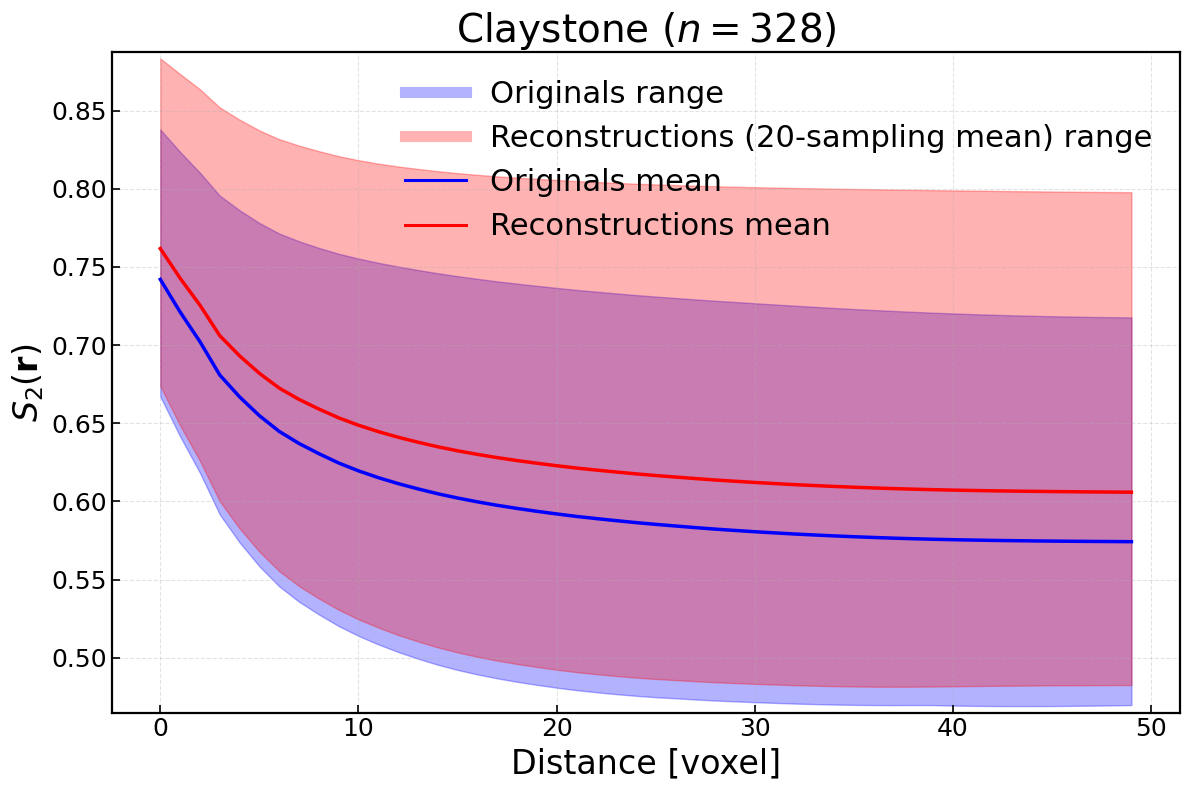

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import glob
import os

CSV_DIR = "./Claystone_tpcf"   
files = sorted(
    glob.glob(os.path.join(CSV_DIR, "sample_*_tpcf_uncertainty.csv")),
    key=lambda p: int(os.path.basename(p).split("_")[1])
)
N = len(files)
print(f"Loaded {N} samples")     

dist = None
orig_list, genm_list, ci_list = [], [], []
ids = []
for fp in files:
    df = pd.read_csv(fp)
    if dist is None:
        dist = df["Distance"].to_numpy()
    orig_list.append(df["Original"].to_numpy())
    genm_list.append(df["Generated_Mean"].to_numpy())
    ids.append(int(os.path.basename(fp).split("_")[1]))

orig_arr = np.vstack(orig_list)      
genm_arr = np.vstack(genm_list)      

def band_stats(arr):
    mean = np.mean(arr, axis=0)
    low  = np.min(arr, axis=0)
    high = np.max(arr, axis=0)
    return mean, low, high

c_orig, c_gen = "#0000FF", "#FF0000"

om, olo, ohi = band_stats(orig_arr)
gm, glo, ghi = band_stats(genm_arr)

fig, ax = plt.subplots(figsize=(12, 8))
ax.fill_between(dist, olo, ohi, color=c_orig, alpha=0.3, label="Originals range")
ax.fill_between(dist, glo, ghi, color=c_gen,  alpha=0.3, label="Reconstructions range")

ax.plot(dist, om, color=c_orig, lw=2.5, label="Originals mean")
ax.plot(dist, gm, color=c_gen,  lw=2.5, label="Reconstructions mean")

ymin = min(olo.min(), glo.min()); ymax = max(ohi.max(), ghi.max())
pad  = 0.01 * (ymax - ymin if ymax > ymin else 1.0)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_xlabel("Distance [voxel]", fontsize=24)
ax.set_ylabel(r"$S_{2}(\mathbf{r})$", fontsize=24)
ax.set_title(rf"Claystone ($n = 328$)", fontsize=28)

ax.grid(True, ls="--", alpha=0.35)
ax.tick_params(axis="both", labelsize=18, direction="in", length=6, width=1.2)
for s in ["top", "right", "bottom", "left"]:
    ax.spines[s].set_linewidth(1.6)
handles = [
    Line2D([0],[0], color=c_orig, lw=8, alpha=0.3, label="Originals range"),
    Line2D([0],[0], color=c_gen,  lw=8, alpha=0.3, label="Reconstructions (20-sampling mean) range"),
    Line2D([0],[0], color=c_orig, lw=2.2, label="Originals mean"),
    Line2D([0],[0], color=c_gen,  lw=2.2, label="Reconstructions mean"),
]
ax.legend(handles=handles, frameon=False, ncol=1, fontsize=22, loc="upper right")
plt.tight_layout()
plt.savefig("./TPCF_Claystone.png", dpi=900, bbox_inches="tight")
plt.show()